Se intentara reentrenar uno de los modelos mas populares ahora mismo, un bert classifier. 
Se espera que se pueda conseguir buenos resultados, y se vera que si.
Debido a un pequeño fallo, en la descarga de el modelo, soy incapaz de reentrenar desde la epoch 3, por lo que voy a volver a entrenar el modelo
y acabare la entrega entonces.

In [4]:
from datasets import load_dataset, load_metric
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from torch.utils.data import DataLoader, Subset

dataset = load_dataset('imdb')

def reduce_dataset(dataset, factor=10):
    reduced_dataset = {}
    for split in dataset.keys():
        labels = np.array(dataset[split]['label'])
        num_per_class = (len(labels) // (2 * factor))
        
        # Get indices for each class
        indices_0 = np.where(labels == 0)[0][:num_per_class]
        indices_1 = np.where(labels == 1)[0][:num_per_class]
        
        # Combine and shuffle indices
        indices = np.concatenate([indices_0, indices_1])
        np.random.shuffle(indices)
        
        # Select the subset
        reduced_dataset[split] = dataset[split].select(indices.tolist())
    return reduced_dataset


reduced_dataset = reduce_dataset(dataset)

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

tokenized_datasets = {}
for split in reduced_dataset.keys():
    tokenized_datasets[split] = reduced_dataset[split].map(tokenize_function, batched=True)

train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy_metric = load_metric('accuracy')

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

results = trainer.evaluate()
print(results)

model.save_pretrained('./trained_model')
tokenizer.save_pretrained('./trained_model')




C:\Users\alfon\anaconda3\envs\text_classification_env\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

C:\Users\alfon\AppData\Local\Temp\ipykernel_26484\1783886435.py:54: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric('accuracy')
C:\Users\alfon\anaconda3\envs\text_classification_env\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
C:\Users\alfon\anaconda3\envs\text_classification_env\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing t

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.276100,0.335924,0.879600,0.821695,0.969600,0.889541
2,0.211400,0.386908,0.901600,0.857550,0.963200,0.907310
3,0.102700,0.366635,0.924000,0.918641,0.930400,0.924483


{'eval_loss': 0.36663535237312317, 'eval_accuracy': 0.924, 'eval_precision': 0.9186413902053713, 'eval_recall': 0.9304, 'eval_f1': 0.924483306836248, 'eval_runtime': 536.5667, 'eval_samples_per_second': 4.659, 'eval_steps_per_second': 0.583, 'epoch': 3.0}


('./trained_model\\tokenizer_config.json',
 './trained_model\\special_tokens_map.json',
 './trained_model\\vocab.txt',
 './trained_model\\added_tokens.json')

Se realiza un entreno extra de 2 epochs, para conseguir informacion adicional del entreno, asi como poder ver cuanto mas puede mejorar
Se entrenara un modelo con 2 epochs mas, y se updateara el github en cuanto sea posible.
Pero se ven mejoras sustanciales de accuracy asi como todo el resto de metricas. El entreno inicial que se realizo aqui fue con el objetivo de checkear su resultado. Solo falta completar la Confusion matrix y puedo finalizar de comentar.

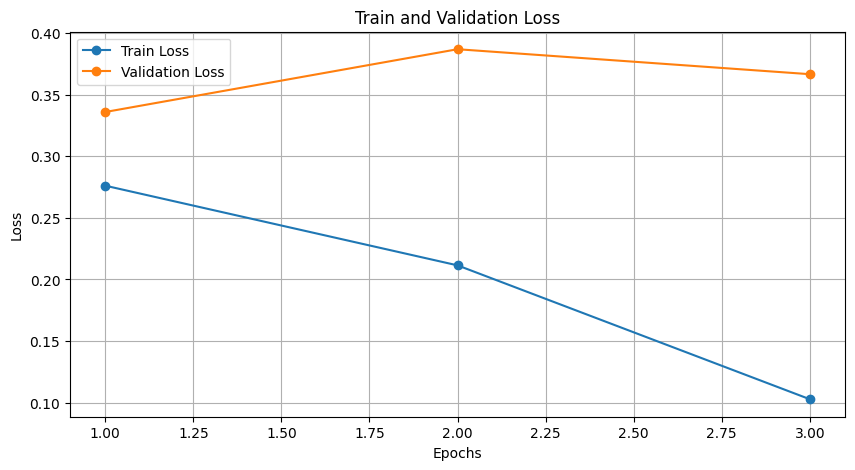

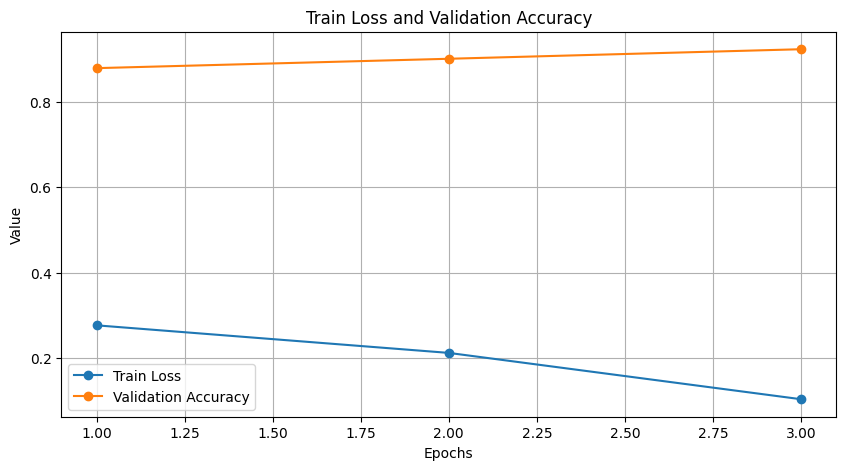

In [8]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3]
train_loss = [0.276100, 0.211400, 0.102700]
val_loss = [0.335924, 0.386908, 0.366635]
accuracy = [0.879600, 0.901600, 0.924000]
precision = [0.821695, 0.857550, 0.918641]
recall = [0.969600, 0.963200, 0.930400]
f1_score = [0.889541, 0.907310, 0.924483]

# Plotting Train and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Train Loss and Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Train Loss and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Se ve que aunque este bajando bastante mas el train loss, lo cual indica una tendencia a sobre entreno, se sigue teniendo muy buenos accuracies, especialmente si lo cmoparamos con los 2 otros modelos. 
El CM se updateara en cuanto se reentrene el modelo.